In [182]:
import numpy as np
from pickle import load, dump
from pathlib import Path
from tqdm import tqdm
from scipy.cluster.vq import vq
import torch
from torchvision.utils import make_grid
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image

from PIL import Image
from multiprocessing import Pool

from scripts.image.kmeans import kmeans

def get_data(root: Path):
    data = None
    for encode_path in tqdm(list(root.glob("*.pk"))):
        with open(encode_path, "rb") as f:
            batch = load(f)
            batch["indxs"] = batch["indxs"].numpy()
        if data is None:
            data = batch
        else:
            data["x"] = np.concatenate([data["x"], batch["x"]])
            data["indxs"] = np.concatenate([data["indxs"], batch["indxs"]])
            data["image_paths"] += batch["image_paths"]
            
    return data

def pca(x, k, center=True):
    # center
    if center:
        m = x.mean(0, keepdim=True)
        s = x.std(0, unbiased=False, keepdim=True)
        x -= m
        x /= s
    # decomposition
    U, S, V = torch.linalg.svd(x)
    reduced = torch.mm(x, V[:k].T)

    return reduced

transform = T.Compose([T.Resize((128, 128)), T.ToTensor()])


def read_image_and_transform(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img)
    return img


def make_image_grid(data, closest, nrow):
    image_paths = [data["image_paths"][i] for i in closest]
    
    with open("closest.txt", "w") as f:
        f.write("\n".join([str(el) for el in image_paths]))
    x = list(
        tqdm(
            map(read_image_and_transform, image_paths),
            total=len(closest),
        )
    )
    grid = make_grid(x, nrow=nrow)

    to_pil_image(grid).save("./rf100-grid=32x56.png")


In [239]:
NUM_CLUSTERS = 32 * 56

In [240]:
data = get_data(Path("./encoded/"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:00<00:00, 431.31it/s]


In [241]:
x = torch.from_numpy(data["x"]).float()
x = pca(x, k=2)
print(f"x.shape={x.shape}")

x.shape=torch.Size([40506, 2])


In [242]:
means, bins = kmeans(x, num_clusters=NUM_CLUSTERS, num_iters=100)

# save to disk
kmeans_outfile_name = f"./torch-kmeans_num-clusters={NUM_CLUSTERS}-pca=2.pk"
with open(kmeans_outfile_name, "wb") as f:
    dump(means, f)

  1%|█▎                                                                                                                                      | 1/100 [00:00<00:39,  2.52it/s]

[0] dists=-93.1324



  2%|██▋                                                                                                                                     | 2/100 [00:00<00:40,  2.44it/s]

[1] dists=-93.1797



  3%|████                                                                                                                                    | 3/100 [00:01<00:40,  2.42it/s]

[2] dists=-93.2161



  4%|█████▍                                                                                                                                  | 4/100 [00:01<00:39,  2.43it/s]

[3] dists=-93.2539



  5%|██████▊                                                                                                                                 | 5/100 [00:02<00:39,  2.43it/s]

[4] dists=-93.2916



  6%|████████▏                                                                                                                               | 6/100 [00:02<00:39,  2.36it/s]

[5] dists=-93.3304



  7%|█████████▌                                                                                                                              | 7/100 [00:02<00:39,  2.36it/s]

[6] dists=-93.3557



  8%|██████████▉                                                                                                                             | 8/100 [00:03<00:38,  2.38it/s]

[7] dists=-93.3656



  9%|████████████▏                                                                                                                           | 9/100 [00:03<00:38,  2.39it/s]

[8] dists=-93.3751



 10%|█████████████▌                                                                                                                         | 10/100 [00:04<00:37,  2.41it/s]

[9] dists=-93.3797



 11%|██████████████▊                                                                                                                        | 11/100 [00:04<00:36,  2.42it/s]

[10] dists=-93.3837



 12%|████████████████▏                                                                                                                      | 12/100 [00:04<00:35,  2.45it/s]

[11] dists=-93.3921



 13%|█████████████████▌                                                                                                                     | 13/100 [00:05<00:35,  2.46it/s]

[12] dists=-93.3966



 14%|██████████████████▉                                                                                                                    | 14/100 [00:05<00:35,  2.45it/s]

[13] dists=-93.3946



 15%|████████████████████▎                                                                                                                  | 15/100 [00:06<00:34,  2.48it/s]

[14] dists=-93.3956



 16%|█████████████████████▌                                                                                                                 | 16/100 [00:06<00:33,  2.47it/s]

[15] dists=-93.3975



 17%|██████████████████████▉                                                                                                                | 17/100 [00:06<00:33,  2.46it/s]

[16] dists=-93.4007



 18%|████████████████████████▎                                                                                                              | 18/100 [00:07<00:33,  2.48it/s]

[17] dists=-93.4032



 19%|█████████████████████████▋                                                                                                             | 19/100 [00:07<00:32,  2.47it/s]

[18] dists=-93.4030



 20%|███████████████████████████                                                                                                            | 20/100 [00:08<00:32,  2.44it/s]

[19] dists=-93.4031



 21%|████████████████████████████▎                                                                                                          | 21/100 [00:08<00:32,  2.46it/s]

[20] dists=-93.4018



 22%|█████████████████████████████▋                                                                                                         | 22/100 [00:09<00:31,  2.45it/s]

[21] dists=-93.4013



 23%|███████████████████████████████                                                                                                        | 23/100 [00:09<00:31,  2.46it/s]

[22] dists=-93.4000



 24%|████████████████████████████████▍                                                                                                      | 24/100 [00:09<00:30,  2.46it/s]

[23] dists=-93.3996



 25%|█████████████████████████████████▊                                                                                                     | 25/100 [00:10<00:30,  2.43it/s]

[24] dists=-93.3996



 26%|███████████████████████████████████                                                                                                    | 26/100 [00:10<00:30,  2.44it/s]

[25] dists=-93.4010



 27%|████████████████████████████████████▍                                                                                                  | 27/100 [00:11<00:29,  2.46it/s]

[26] dists=-93.4020



 28%|█████████████████████████████████████▊                                                                                                 | 28/100 [00:11<00:29,  2.46it/s]

[27] dists=-93.4024



 29%|███████████████████████████████████████▏                                                                                               | 29/100 [00:11<00:28,  2.45it/s]

[28] dists=-93.4030



 30%|████████████████████████████████████████▌                                                                                              | 30/100 [00:12<00:28,  2.47it/s]

[29] dists=-93.4032



 31%|█████████████████████████████████████████▊                                                                                             | 31/100 [00:12<00:27,  2.47it/s]

[30] dists=-93.4033



 32%|███████████████████████████████████████████▏                                                                                           | 32/100 [00:13<00:27,  2.45it/s]

[31] dists=-93.4034



 33%|████████████████████████████████████████████▌                                                                                          | 33/100 [00:13<00:27,  2.45it/s]

[32] dists=-93.4038



 34%|█████████████████████████████████████████████▉                                                                                         | 34/100 [00:13<00:27,  2.43it/s]

[33] dists=-93.4043



 35%|███████████████████████████████████████████████▎                                                                                       | 35/100 [00:14<00:26,  2.44it/s]

[34] dists=-93.4052



 36%|████████████████████████████████████████████████▌                                                                                      | 36/100 [00:14<00:26,  2.45it/s]

[35] dists=-93.4059



 37%|█████████████████████████████████████████████████▉                                                                                     | 37/100 [00:15<00:25,  2.45it/s]

[36] dists=-93.4064



 38%|███████████████████████████████████████████████████▎                                                                                   | 38/100 [00:15<00:25,  2.44it/s]

[37] dists=-93.4070



 39%|████████████████████████████████████████████████████▋                                                                                  | 39/100 [00:15<00:25,  2.43it/s]

[38] dists=-93.4070



 40%|██████████████████████████████████████████████████████                                                                                 | 40/100 [00:16<00:24,  2.43it/s]

[39] dists=-93.4071



 41%|███████████████████████████████████████████████████████▎                                                                               | 41/100 [00:16<00:24,  2.44it/s]

[40] dists=-93.4071



 42%|████████████████████████████████████████████████████████▋                                                                              | 42/100 [00:17<00:23,  2.45it/s]

[41] dists=-93.4071



 43%|██████████████████████████████████████████████████████████                                                                             | 43/100 [00:17<00:23,  2.45it/s]

[42] dists=-93.4071



 44%|███████████████████████████████████████████████████████████▍                                                                           | 44/100 [00:18<00:22,  2.46it/s]

[43] dists=-93.4071



 45%|████████████████████████████████████████████████████████████▊                                                                          | 45/100 [00:18<00:22,  2.43it/s]

[44] dists=-93.4071



 46%|██████████████████████████████████████████████████████████████                                                                         | 46/100 [00:18<00:22,  2.43it/s]

[45] dists=-93.4071



 47%|███████████████████████████████████████████████████████████████▍                                                                       | 47/100 [00:19<00:22,  2.40it/s]

[46] dists=-93.4071



 48%|████████████████████████████████████████████████████████████████▊                                                                      | 48/100 [00:19<00:21,  2.42it/s]

[47] dists=-93.4071



 49%|██████████████████████████████████████████████████████████████████▏                                                                    | 49/100 [00:20<00:20,  2.44it/s]

[48] dists=-93.4071



 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 50/100 [00:20<00:20,  2.44it/s]

[49] dists=-93.4071



 51%|████████████████████████████████████████████████████████████████████▊                                                                  | 51/100 [00:20<00:19,  2.46it/s]

[50] dists=-93.4071



 52%|██████████████████████████████████████████████████████████████████████▏                                                                | 52/100 [00:21<00:19,  2.46it/s]

[51] dists=-93.4071



 53%|███████████████████████████████████████████████████████████████████████▌                                                               | 53/100 [00:21<00:19,  2.46it/s]

[52] dists=-93.4071



 54%|████████████████████████████████████████████████████████████████████████▉                                                              | 54/100 [00:22<00:18,  2.47it/s]

[53] dists=-93.4071



 55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 55/100 [00:22<00:18,  2.48it/s]

[54] dists=-93.4071



 56%|███████████████████████████████████████████████████████████████████████████▌                                                           | 56/100 [00:22<00:17,  2.48it/s]

[55] dists=-93.4071



 57%|████████████████████████████████████████████████████████████████████████████▉                                                          | 57/100 [00:23<00:17,  2.49it/s]

[56] dists=-93.4071



 58%|██████████████████████████████████████████████████████████████████████████████▎                                                        | 58/100 [00:23<00:16,  2.49it/s]

[57] dists=-93.4071



 59%|███████████████████████████████████████████████████████████████████████████████▋                                                       | 59/100 [00:24<00:16,  2.48it/s]

[58] dists=-93.4071



 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 60/100 [00:24<00:16,  2.48it/s]

[59] dists=-93.4071



 61%|██████████████████████████████████████████████████████████████████████████████████▎                                                    | 61/100 [00:24<00:15,  2.47it/s]

[60] dists=-93.4071



 62%|███████████████████████████████████████████████████████████████████████████████████▋                                                   | 62/100 [00:25<00:15,  2.44it/s]

[61] dists=-93.4071



 63%|█████████████████████████████████████████████████████████████████████████████████████                                                  | 63/100 [00:25<00:15,  2.45it/s]

[62] dists=-93.4071



 64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                | 64/100 [00:26<00:14,  2.47it/s]

[63] dists=-93.4071



 65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 65/100 [00:26<00:14,  2.45it/s]

[64] dists=-93.4071



 66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 66/100 [00:26<00:13,  2.46it/s]

[65] dists=-93.4071



 67%|██████████████████████████████████████████████████████████████████████████████████████████▍                                            | 67/100 [00:27<00:13,  2.42it/s]

[66] dists=-93.4071



 68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 68/100 [00:27<00:13,  2.42it/s]

[67] dists=-93.4071



 69%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 69/100 [00:28<00:12,  2.46it/s]

[68] dists=-93.4071



 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 70/100 [00:28<00:12,  2.45it/s]

[69] dists=-93.4071



 71%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 71/100 [00:29<00:12,  2.39it/s]

[70] dists=-93.4071



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 72/100 [00:29<00:11,  2.34it/s]

[71] dists=-93.4071



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 73/100 [00:29<00:11,  2.30it/s]

[72] dists=-93.4071



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 74/100 [00:30<00:11,  2.28it/s]

[73] dists=-93.4071



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 75/100 [00:30<00:11,  2.27it/s]

[74] dists=-93.4071



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 76/100 [00:31<00:10,  2.28it/s]

[75] dists=-93.4071



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 77/100 [00:31<00:10,  2.29it/s]

[76] dists=-93.4071



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 78/100 [00:32<00:09,  2.29it/s]

[77] dists=-93.4071



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 79/100 [00:32<00:09,  2.31it/s]

[78] dists=-93.4071



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 80/100 [00:33<00:08,  2.25it/s]

[79] dists=-93.4071



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 81/100 [00:33<00:08,  2.31it/s]

[80] dists=-93.4071



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 82/100 [00:33<00:07,  2.35it/s]

[81] dists=-93.4071



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 83/100 [00:34<00:07,  2.39it/s]

[82] dists=-93.4071



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 84/100 [00:34<00:06,  2.43it/s]

[83] dists=-93.4071



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 85/100 [00:35<00:06,  2.45it/s]

[84] dists=-93.4071



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 86/100 [00:35<00:05,  2.39it/s]

[85] dists=-93.4071



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 87/100 [00:35<00:05,  2.42it/s]

[86] dists=-93.4071



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 88/100 [00:36<00:05,  2.35it/s]

[87] dists=-93.4071



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 89/100 [00:36<00:04,  2.38it/s]

[88] dists=-93.4071



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 90/100 [00:37<00:04,  2.41it/s]

[89] dists=-93.4071



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 91/100 [00:37<00:03,  2.42it/s]

[90] dists=-93.4071



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 92/100 [00:37<00:03,  2.45it/s]

[91] dists=-93.4071



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 93/100 [00:38<00:02,  2.44it/s]

[92] dists=-93.4071



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 94/100 [00:38<00:02,  2.44it/s]

[93] dists=-93.4071



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 95/100 [00:39<00:02,  2.45it/s]

[94] dists=-93.4071



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 96/100 [00:39<00:01,  2.47it/s]

[95] dists=-93.4071



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 97/100 [00:39<00:01,  2.48it/s]

[96] dists=-93.4071



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 98/100 [00:40<00:00,  2.47it/s]

[97] dists=-93.4071



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:40<00:00,  2.49it/s]

[98] dists=-93.4071


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]

[99] dists=-93.4071


In [302]:
# from disk
with open(kmeans_outfile_name, "rb") as f:
    means = load(f)
    means = means

print(f"Loaded means, shape={means.shape}")

Loaded means, shape=torch.Size([1792, 2])


In [303]:
x_np = x.numpy()

In [304]:
# means_closest = torch.norm(means[0] - means, dim=1)

# means = means[torch.argsort(means_closest)]

means_np = means.numpy()

In [305]:
all_closest = []


temp = x_np.copy()
temp = np.sort(temp)

means_np = np.sort(means_np)

for mean in tqdm(means_np):
    closest, distances = vq(mean[None,:], temp)
    all_closest.append(closest)
    temp[closest] = np.ones_like(temp[closest]) * 10e6



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1792/1792 [00:00<00:00, 6128.81it/s]


In [306]:
closest = np.array(all_closest).flatten()

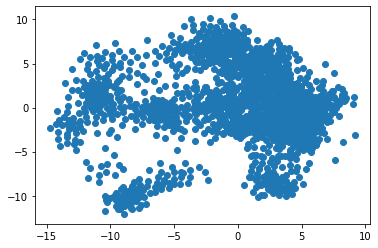

In [307]:
import matplotlib.pyplot as plt

points = x[closest]

plt.scatter(points[:,0], points[:,1])

In [308]:
np.unique(closest).shape, closest.shape

((1792,), (1792,))

In [309]:
make_image_grid(data, closest, nrow=56)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1792/1792 [00:06<00:00, 280.71it/s]
